In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/age_gender.csv')
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


# Preprocessing

In [ ]:
data.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [ ]:
data = data.drop('img_name', axis=1)

In [ ]:
{column: list(data[column].unique()) for column in ['gender', 'ethnicity', 'age']}

In [ ]:
data['age'] = pd.qcut(data['age'], q=10, labels=[0, 1, 2, 3,4,5,6,7,8,9])
data

,age,ethnicity,gender,pixels
0,0,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,0,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,0,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,0,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,0,2,0,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...
23700,9,0,1,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,9,1,1,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,9,2,1,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,9,2,1,45 108 120 156 206 197 140 180 191 199 204 207...


In [ ]:
print(len(data['pixels'][0].split(' ')))
print(np.sqrt(2304))

2304
48.0


In [ ]:
num_pixels = 2304
img_height = 48
img_width = 48

In [ ]:
target_columns = ['gender', 'ethnicity', 'age']

y = data[target_columns]
X = data.drop(target_columns, axis=1)
y

,gender,ethnicity,age
0,0,2,0
1,0,2,0
2,0,2,0
3,0,2,0
4,0,2,0
...,...,...,...
23700,1,0,9
23701,1,1,9
23702,1,2,9
23703,1,2,9


In [ ]:
X

,pixels
0,129 128 128 126 127 130 133 135 139 142 145 14...
1,164 74 111 168 169 171 175 182 184 188 193 199...
2,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,193 197 198 200 199 200 202 203 204 205 208 21...
4,202 205 209 210 209 209 210 211 212 214 218 21...
...,...
23700,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,45 108 120 156 206 197 140 180 191 199 204 207...


In [ ]:
X = pd.Series(X['pixels'])
X = X.apply(lambda x: x.split(' '))
X = X.apply(lambda x: np.array(list(map(lambda z: np.int(z), x))))
X = np.array(X)
X = np.stack(np.array(X), axis=0)
X = np.reshape(X, (-1, 48, 48))

X.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


(23705, 48, 48)

# Visualization

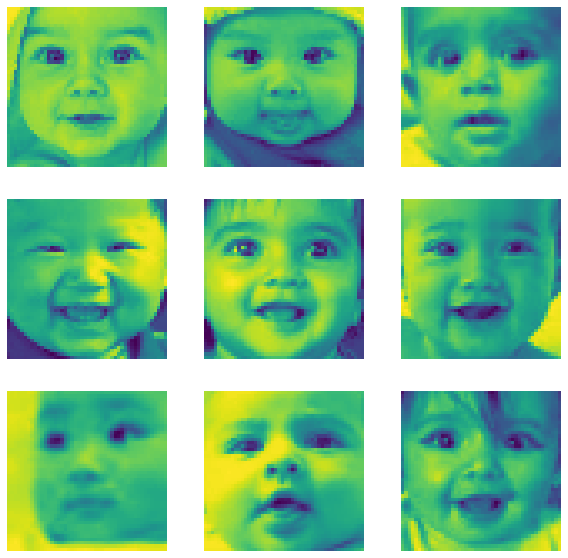

In [ ]:
plt.figure(figsize=(10, 10))

for index, image in enumerate(np.random.randint(0, 1000, 9)):
    plt.subplot(3, 3, index + 1)
    plt.imshow(X[image])
    plt.axis('off')

plt.show()

# Training

In [ ]:
y_gender = np.array(y['gender'])
y_ethnicity = np.array(y['ethnicity'])
y_age = np.array(y['age'])

In [ ]:
X.shape

(23705, 48, 48)

In [ ]:
def build_model(num_classes, activation='softmax', loss='sparse_categorical_crossentropy'):

    inputs = tf.keras.Input(shape=(img_height, img_width, 1))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation=activation)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)


    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [ ]:
{column: list(data[column].unique()) for column in ['gender', 'ethnicity', 'age']}

{'age': [0, 1, 9, 2, 3, 4, 5, 6, 7, 8],
 'ethnicity': [2, 3, 4, 0, 1],
 'gender': [0, 1]}

In [ ]:
X_gender_train, X_gender_test, y_gender_train, y_gender_test = train_test_split(X, y_gender, train_size=0.7)
X_ethnicity_train, X_ethnicity_test, y_ethnicity_train, y_ethnicity_test = train_test_split(X, y_ethnicity, train_size=0.7)
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X, y_age, train_size=0.7)

# Gender Model

In [ ]:
gender_model = build_model(1, activation='sigmoid', loss='binary_crossentropy')

gender_history = gender_model.fit(
    X_gender_train,
    y_gender_train,
    validation_split=0.2,
    batch_size=64,
    epochs=20,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=0
)

In [ ]:
fig = px.line(
    gender_history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Gender Model"
)

fig.show()

In [ ]:
gender_acc = gender_model.evaluate(X_gender_test, y_gender_test)[1]

223/223 [==============================] - 5s 22ms/step - loss: 0.4133 - accuracy: 0.8867


# Ethnicity Model

In [ ]:
ethnicity_model = build_model(5, activation='softmax', loss='sparse_categorical_crossentropy')

ethnicity_history = ethnicity_model.fit(
    X_ethnicity_train,
    y_ethnicity_train,
    validation_split=0.2,
    batch_size=64,
    epochs=20,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=0
)

In [ ]:
fig = px.line(
    ethnicity_history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Ethnicity Model"
)

fig.show()

In [ ]:
ethnicity_acc = ethnicity_model.evaluate(X_ethnicity_test, y_ethnicity_test)[1]

223/223 [==============================] - 5s 22ms/step - loss: 0.9673 - accuracy: 0.7570


# Age Model

In [ ]:
age_model = build_model(10, activation='softmax', loss='sparse_categorical_crossentropy')

age_history = age_model.fit(
    X_age_train,
    y_age_train,
    validation_split=0.2,
    batch_size=64,
    epochs=20,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=0
)

In [ ]:
fig = px.line(
    age_history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Age Model"
)

fig.show()

In [ ]:
age_acc = age_model.evaluate(X_age_test, y_age_test)[1]

223/223 [==============================] - 5s 22ms/step - loss: 2.0607 - accuracy: 0.3920


# Results

In [ ]:
fig = px.bar(
    x=["Gender", "Ethnicity", "Age"],
    y=[gender_acc, ethnicity_acc, age_acc],
    labels={'x': "", 'y': "Accuracy"},
    color=["Gender", "Ethnicity", "Age"],
    title="Model Performance"
)

fig.show()